# Optosurf 32 pixel line detector 
The Optosurf head is able to detect scattered light in order to measure roughness. The roughness of a sample can be determined from the shape of the optical field that goes into the detector, for rougher samples the optical field will be wider. The optosurf is also able to determine the lateral shift of the optical field, this is equivalent to the incoming angle of the sample's reflected light.

In order to sample the optical field, the optosurf head has a 32-pixel linear detector within +-15 deg on-axis. The optical field is sampled by performing a window integration over each pixel, obtaining 32 sampling points. The measured parameter to characterize the sample roughness is called <span style="color:#3E78B2">Aq</span> and is calculated by reconstructing a histogram of the sampling points. The sampling process of the optical field and Aq value calculation is illustrated in @fig-2-1.

![a. Optical field definition. b. Window integration. c. Histogram](figures/a/fig_1_optical_field.png){#fig-2-1}

## Optical field and window integration simulation

The optosurf signal is reconstructed from the 32 sampling points. Such sampling points characterize the roughness of any given sample through the parameters $\mu$ and $\sigma$. The $\mu$ parameter relates to the incoming angle of the sample's reflected light, this is equivalent to a lateral shift of the optical field. The $\sigma$ parameter relates roughness of the sample and determines the width of the optical field. 

This is shown in @fig-2-2. When a wafer is rotated the optosurf signal is displaced along the linear detector, while increasing the sample roughness widens the optosurf signal through the $\sigma$ parameter.


![a. Effect of changing the angle of the incoming light. b. Effect of increasing sample roughness](figures/a/fig_2_wafer_rotation.png){#fig-2-2}

In order to simulate this, the equation of an optical field is defined as:

$y = e^{-((x-\mu)/\sigma)^n}$

Then, different parameters for $\mu$ and $\sigma$ are used to simulate different optical fields over a range of 30 degrees from -15 to 15, as shown in @fig-2-3-histogram (a). Notice when changing $\mu$ from -4.0 to 4.0 the optical field is displaced along the linear detector. When changing $\sigma$ from 1.0 to 2.5 the optical field is widened. 

In order to simulate the linear array detector, a window integration was performed over the optical field representing each pixel. This is represented by the green rectangles in @fig-2-3-histogram. Notice how for optical field with narrower peaks there are fewer sampling points (green points), while for wider peaks there are more sampling points. This directly relates to the Aq parameter that is calculated from the histogram of the sampling points as shown in @fig-2-3-histogram b.

For the case of very smooth wafer the type of signal that is expected is a very narrow signal (small $\sigma$), hence the Aq parameter will be limited to only a few sampling points along the main peak and across the tails of the signal.

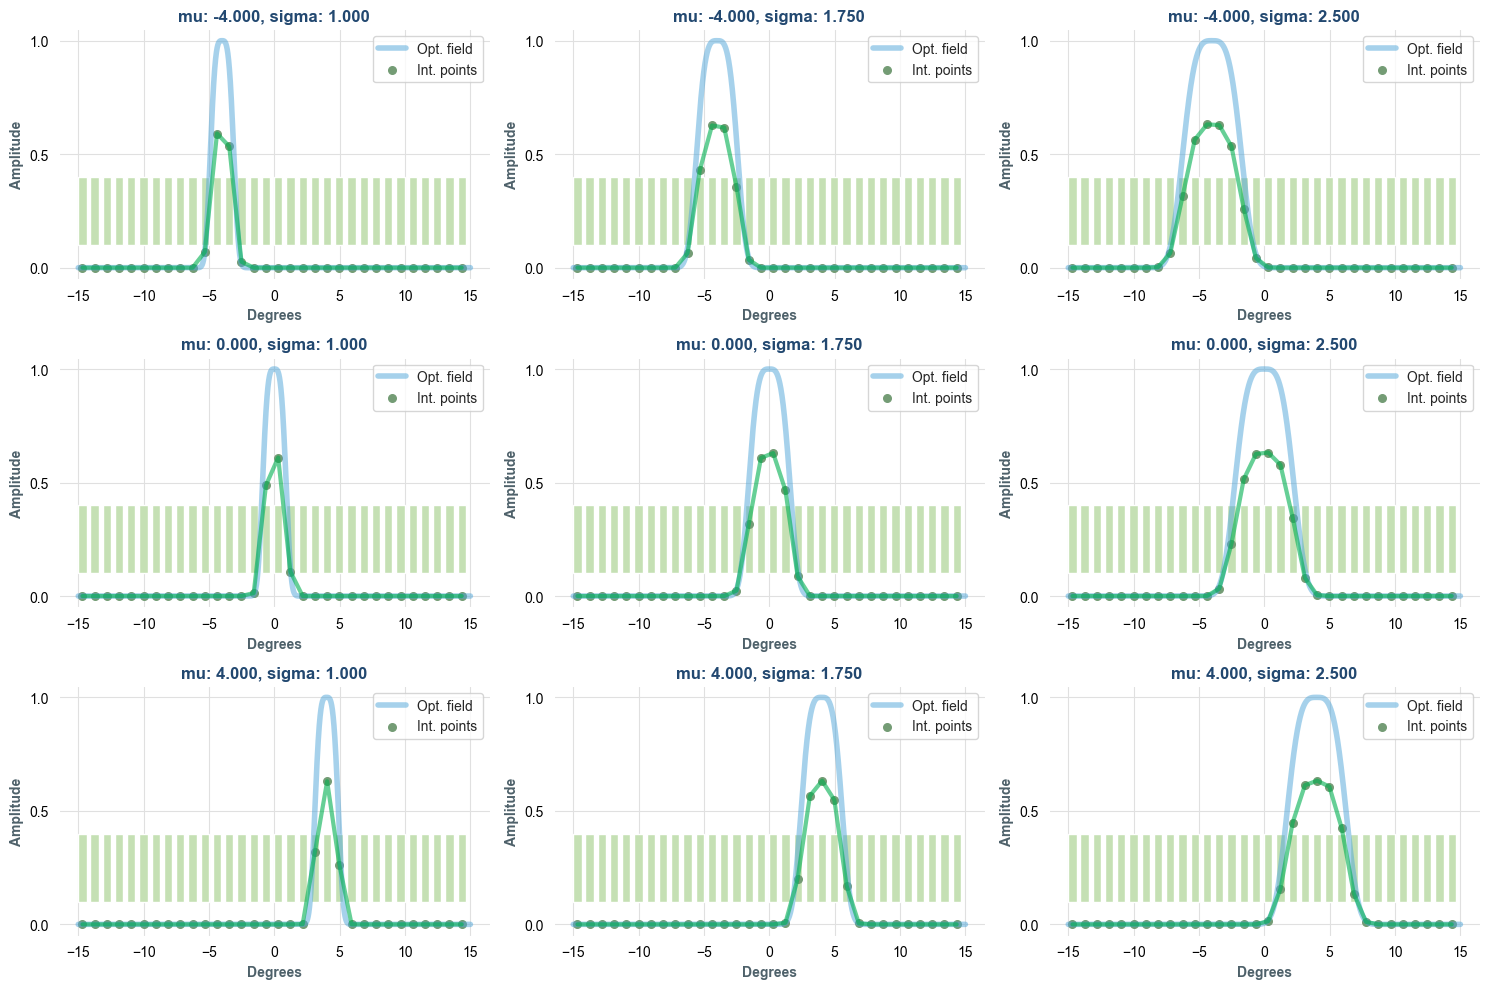

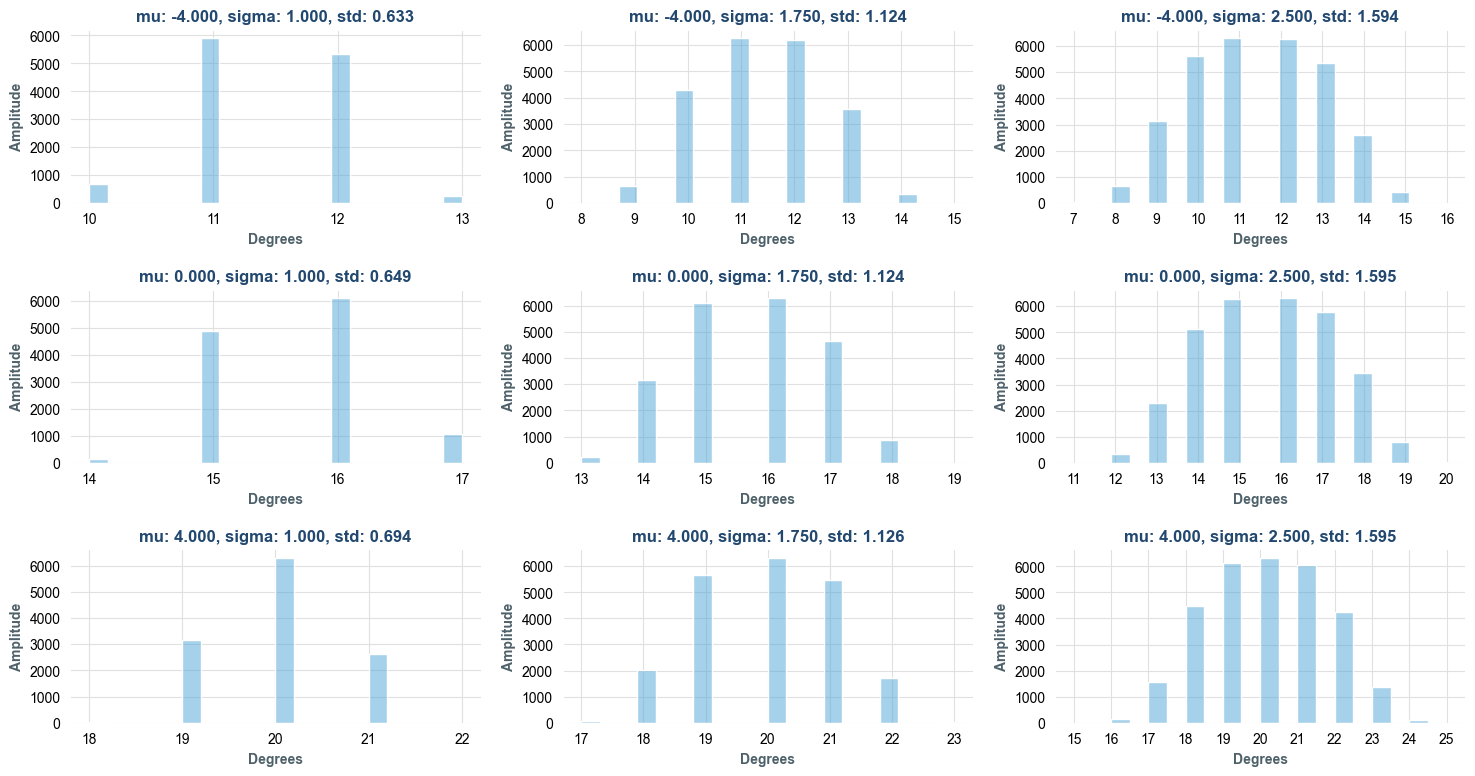

In [4]:
#| label: fig-2-3-histogram
#| fig-cap: "Window sampling and Aq histogram reconstruction for different optical fields."
#| fig-subcap:
#|   - "Optical field window sampling"
#|   - "Aq histogram reconstruction"
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 

# define your custom theme as a dictionary of parameters
my_theme = {
    "figure.facecolor": "white", 
    "axes.facecolor": "white", # green
    "axes.edgecolor": "white",
    "axes.labelcolor": "#4E616A",
    "axes.grid": True,
    "grid.color": "#E0E0E0",
    "xtick.color": "black",
    "ytick.color": "black",
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "Tahoma"]
}


def seaborn_grid(axes, plot_count, x, y, title):
    row = plot_count // cols
    col = plot_count % cols
    axes[row, col].plot(x, y, color = '#4EA5D9', linewidth=4)
    axes[row, col].set_title(title, color = '#224870', fontweight='bold')
    axes[row, col].set_xlabel('Degrees', fontweight='bold')
    axes[row, col].set_ylabel('Amplitude', fontweight='bold')
    axes[row, col].xaxis.set_major_locator(plt.MultipleLocator(5))  # Set x-axis tick frequency
    axes[row, col].yaxis.set_major_locator(plt.MultipleLocator(0.5))  # Set y-axis tick frequency

def plot_format_plt(xlabel, ylabel, xticks, yticks, ax):
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.xaxis.set_major_locator(plt.MultipleLocator(xticks))  # Set x-axis tick frequency
    ax.yaxis.set_major_locator(plt.MultipleLocator(yticks))

def window_integration(axes, number_windows, window_size, gap, x, y, plot_bool):
    integration_points = []
    integration_axis = []
    count = 0

    for i in range(number_windows):
    # 1. Get data in every window and integrate
        a = i*window_size
        b = i*window_size + window_size
        
        x_temp = x[a:b-gap:1]
        y_temp = y[a:b-gap:1]

        left_edge = x_temp[0]
        right_edge = x_temp[-1]
        if plot_bool:
            axes[row, col].bar(x=(left_edge + right_edge)/2, height=0.3, width=right_edge-left_edge, bottom=0.1, alpha=1, color='#C5E0B4')
        
        integration = np.trapz(y_temp, x_temp, dx = x[1] - x[0])
        integration_points.append(integration)

        axis = x_temp[len(x_temp)//2]
        integration_axis.append(axis)

    return integration_axis, integration_points


def histogram_reconstruction(int_points):
    """
    Constructs a histrogram

    Parameters
    ----------
    int_points(np): Points calculated from the window integration
    Returns
    -------
    hist_plot (bokeh plot): Plot of the histogram
    std_dev(float): Histogram's standard deviation
    """

    # a. Histogram reconstruction
    normalized_y = np.multiply(int_points, 10000)
    hist_2d = np.array([])
    for i, int_point in enumerate(normalized_y):
        round_int_point = round(float(int_point))
        hist_2d = np.concatenate((hist_2d, np.array([float(i)]*round_int_point)))
    
    return hist_2d




# 1. Define input parameters for the optical field
mu_np = np.linspace(-4, 4, 3)
std_np = np.linspace(1.0, 2.5, 3)
X, Y = np.meshgrid(mu_np, std_np)
n = 3.5
number_points = 10000
degrees = [-15, 15]
number_windows = 32
window_size = number_points//number_windows
gap = 100
std_deviation = {}

# 2. Define seaborn subplot
fig, axes = plt.subplots(3, 3, figsize=(15, 10), squeeze=False)
fig_hist, hist_axes = plt.subplots(3, 3, figsize=(18, 9), squeeze=False, gridspec_kw={'hspace': 0.5})
cols = 3
plot_count = 0

# 3. Iterate through mu and sigma values
for i in range(len(mu_np)):
    for j in range(len(std_np)):
        # a. Calculate window integration
        title = f"mu: {mu_np[i]:.3f}, sigma: {std_np[j]:.3f}"
        x = np.linspace(degrees[0], degrees[1], number_points)
        y = np.exp(-abs(((x-mu_np[i])/std_np[j]))**n)

        # b. Plot the optical field
        row = plot_count // cols
        col = plot_count % cols
        axes[row, col].set_title(title, color = '#224870', fontweight='bold')
        axes[row, col].plot(x, y, color = '#4EA5D9', linewidth=4, label='Opt. field', alpha = 0.5)
        
        # c. Window integration
        integration_axis, integration_points = window_integration(axes, number_windows, window_size, gap, x, y, True)
        axes[row,col].plot(integration_axis, integration_points, color = '#00B050', linewidth=3, alpha = 0.6)
        axes[row, col].scatter(integration_axis, integration_points, color = '#749C75', s = 30, label='Int. points')
        axes[row, col].legend()
        plot_count += 1
        plot_format_plt('Degrees', 'Amplitude', 5, 0.5, axes[row, col])

        # d. Histogram reconstruction
        hist_2d = histogram_reconstruction(integration_points)
        sns.histplot(data=hist_2d, ax=hist_axes[row, col], bins=20, color='#4EA5D9', alpha=0.5, )
        std_dev = np.std(hist_2d)
        title = title + f", std: {std_dev:.3f}"
        hist_axes[row, col].set_title(title, color = '#224870', fontweight='bold')
        plot_format_plt('Degrees', 'Amplitude', 1, 1000, hist_axes[row, col])

# set the custom theme using the rc parameter
sns.set_style("white", rc=my_theme)
fig.tight_layout()
plt.show()


## Aq parameter limitations

From the simulation of the linear array, it was learnt that the Aq parameter depends on the width of the optical field. In the case of a smooth wafer, the optical field is very narrow and the Aq parameter is limited to only a few sampling points. Additionaly, the Aq parameter is dependent on the incoming angle of the sample's reflected light, hence being angle sensitive. This is illustrated in @fig-2-4:

In [5]:
number_points = 5000
number_windows = 32
window_size = number_points//number_windows
gap = 100
n = 3.5
degrees = [-15, 15]
           
mu_range = [-5, 5]
axis_range = [mu_range[0], mu_range[1], 0.5]
axis_range = np.arange(-5, 5.5, 0.5)
mu_step = 0.10
mu_points = (mu_range[1] - mu_range[0])//mu_step

std_range = [1.0, 3.5]
std_step = 0.5 
std_points = 0.5


mu_np = np.linspace(mu_range[0], mu_range[1], int(mu_points))
std_np = np.arange(std_range[0], std_range[1], std_points)
X, Y = np.meshgrid(mu_np, std_np)
std_grid = np.empty_like(X)

# Iterates mu and standard deviation
grids_Aq = {}

for j in range(len(std_np)):
    grids_Aq[std_np[j]] = np.zeros((1,len(mu_np)))
    for i in range(len(mu_np)):
        # print(f"mu: {mu_np[i]:.3f}")
        x = np.linspace(degrees[0], degrees[1], number_points)
        y = np.exp(-abs(((x-mu_np[i])/std_np[j]))**n)

        # b. Window integration
        integration_axis, integration_points = window_integration(axes, number_windows, window_size, gap, x, y, True)
        
        # # c. Histogram reconstruction
        hist_2d = histogram_reconstruction(integration_points)

        # d. Calculate Aq
        grids_Aq[std_np[j]][0,i] = np.std(hist_2d)

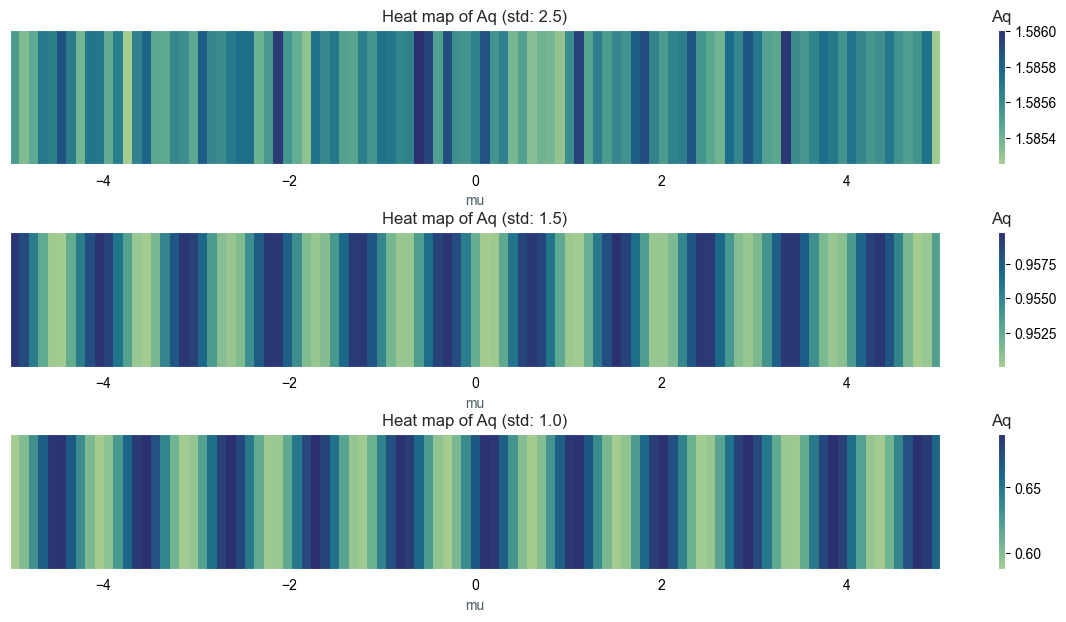

In [6]:
#| column: page
#| label: fig-2-4
#| fig-cap: "Aq values as function of mu and standard deviation"

# create a grid of 3 rows and 1 column
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 7), gridspec_kw={'hspace': 0.5})

# loop over the standard deviations and plot the heat maps
for i, std in enumerate([2.5, 1.5, 1.0]):
    im = axs[i].imshow(grids_Aq[std], cmap='crest', aspect='auto', extent=[mu_range[0], mu_range[1], 1.0, 1.1])
    axs[i].set_xlabel('mu')
    axs[i].set_ylabel('Standard deviation (std)')
    axs[i].set_title(f'Heat map of Aq (std: {std})')
    axs[i].grid(False)
    axs[i].yaxis.set_visible(False)
    cbar = fig.colorbar(im, ax=axs[i])
    cbar.ax.set_title('Aq')

From the previous figure the Aq has the following limitations:

- The variation of Aq parameter is small for wider optical fields (larger $\sigma$). 
- In contrast, the variation of Aq parameter increases for narrower optical fields (smaller $\sigma$).
- The Aq parameter is angle sensitive, specially for optical fields with narrower peaks (smaller $\sigma$).

Because of this limitations the Aq parameter would be able to distinguish between samples with very different roughness, but it would not be able to distinguish between samples with similar roughness, specially with a nm roughness variation.




\newpage